# Hands-On Validation and Evaluation Metrics Solutions
***

In this notebook we'll investigate Scikit-Learn's functionality for performing cross-validation, plotting ROC curves, and plotting learning curves. 

**Note**: There are some helper functions at the bottom of this notebook.  Scroll down and execute those cells before continuing. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

### Part 1: Data Examination and Visualization
***

The data we will explore in this notebook is the so-called Spambase data, which contains features extracted from SPAM and HAM emails.  The following cell will load the data. 

In [2]:
data = pd.read_csv("data/spamdata.csv", sep=" ")
X, y = data.values[:,:-1], data.values[:,-1]
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,isSPAM
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


**Part A**: The features in in this dataset are a combination of frequency counts for select words as well as other numerical features derived from the original email text.  Some of the word-count features included are things like 

- `word_freq_order`: percentage of words in the email that are the word `order` 
- `word_freq_free`: percentage of words in the email that are the word `free` 

A few other relevant features are things like 

- `capital_run_length_average`: the average length of a run of capital letters 
- `capital_run_length_longest`: the longest length of a run of capital letters 
- `char_freq_!`: the number of exclamation points that appear in the email 

Descriptions of the rest of the features can be found [here](http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names). 

**Part B**: 

Let's visualize some of the features by plotting histograms of the features colored by whether the email is SPAM or HAM. It seems like the number of contiguous capital letters should be a good indicator of SPAM... 

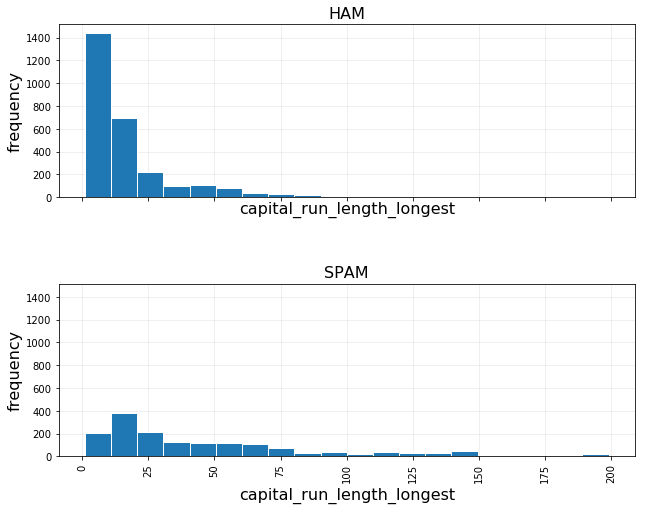

In [4]:
feature_hist(data, "capital_run_length_longest", 200)

And probably also the number of exclamation points ... 

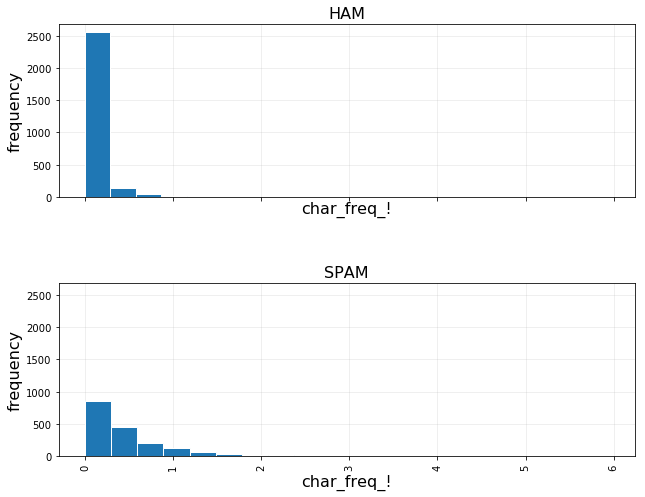

In [5]:
feature_hist(data, "char_freq_!", 6)

### Part 2: Estimating Model Performance with Cross-Validation 
***

In this section we'll use sklearn's built in cross-validation routine to estimate the accuracy of logistic regression for our data set.  

**Part A**: First, let's set a baseline by performing a train-validation split on the data and then fitting a logistic regression model. 

In [3]:
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1734)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train);

Next we'll evaluate the error on the validation set and see how well we did. 

In [7]:
print("validation accuracy: {:.3f}".format(logreg.score(X_valid, y_valid)))

validation accuracy: 0.927


**Part B**: OK, so suppose we're not willing to lose 40% of our data to a validation set.  We can do k-Folds Cross-Validation to use all of our data to get a more informed estimate of our classification accuracy. We can do this with sklearn's [cross_validate](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) routine.  

Notice that `cross_validate` takes in an `estimator` indicating which model to use as well as a parameter `cv` which indicates how many folds to use. The function returns a dictionary containing things like `test_score`, `train_score`, `fit_time`, etc.  We're interested in the array containing `test_score` as this gives the accuracies computed on the held-out validation sets. 

Try it now with $k=5$ folds. 

In [24]:
from sklearn.model_selection import cross_validate 

scores = cross_validate(LogisticRegression(), X, y, cv=5)

mean_score = 0.0 # TODO 
print("mean score: {:.3f}".format(mean_score))

mean score: 0.000


**Part C**: We might also want a 95% confidence interval for the cross-validation accuracy.  Since we only have $k=5$ samples, and we're not entirely certain that the distribution of the accuracies is normal, the safest thing to do is Bootstrap the accuracy estimate.  

The one hitch here is that `cross_validate` does not accept a `random_state` flag so running `cross_validate` multiple times will yield the same results.  We can fix this by passing in a cross-validation iterator for the `cv` parameter that will randomly split the data into different folds.  Note that here we use the iterator `StratifiedKFold` because it guarantees that we get a similar proportion of each target class in each fold.  

We'll do 40 runs of $5$-Folds Cross-Validation to obtain $200$ measurements of the accuracy. 

In [9]:
from sklearn.model_selection import StratifiedKFold

all_test_scores = []

for ii in range(40):
    scores = cross_validate(LogisticRegression(), X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=None))
    all_test_scores = all_test_scores + list(scores["test_score"])

We can then plot a histogram of the accuracy measurements. 

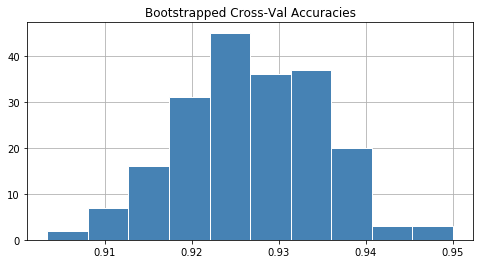

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
pd.DataFrame(all_test_scores).hist(ax=ax, color=mycolors["blue"], edgecolor="white")
ax.set_axisbelow(True)
ax.set_title("Bootstrapped Cross-Val Accuracies")

We can then get a 95% bootstrapped confidence interval by finding the $2.5^\textrm{th}$ and $97.5^\textrm{th}$ percentiles of the bootstrapped samples.  

In [11]:
print("Bootstrapped Mean: {:.3f}".format(np.mean(all_test_scores)))
print("Bootstrapped 95% CI: [{:.3f}, {:.3f}]".format(np.percentile(all_test_scores, 2.5), np.percentile(all_test_scores, 97.5)))

Bootstrapped Mean: 0.927
Bootstrapped 95% CI: [0.912, 0.941]


So we're 95% confident that the true generalization accuracy lies between $0.91$ and $0.94$.  If we run this for many more samples then we could likely get a better estimate. 

### Part 3: Evaluating Model Performance with the ROC curve 
***

Note that SPAM classification is an application in which we might want to finely tune the true positive rate and false positive rate of our classifier. 

**Part A**: Think about SPAM classification.  What kinds of classification errors would be the most detrimental? 


**Part B**: Let's plot a ROC curve for our Logistic Regression classifier. Sklearn's [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) routine computes the FPR and TPR for a range of possible thresholds in the data which you can then use to plot. Check out the documentation, and then fill in the code below to plot the curve for our Logistic Regression SPAM classifier. 

(FPR, TPR) = (0.010, 0.363)


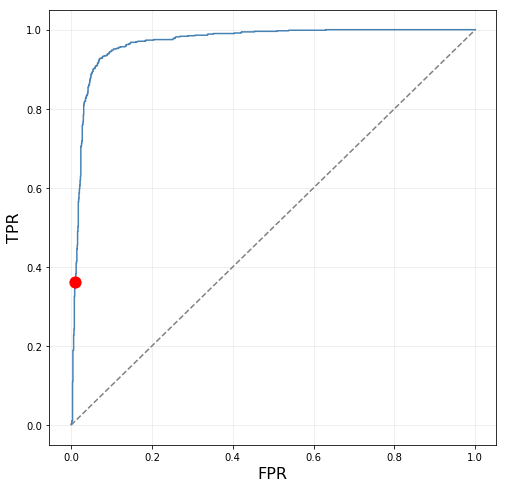

In [23]:
from sklearn.metrics import roc_curve

logreg = LogisticRegression() 
logreg.fit(X_train, y_train)
y_valid_scores = logreg.predict_proba(X_valid)[:,1]

FPR, TPR, thresholds = roc_curve(y_valid, y_valid_scores)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.plot(FPR, TPR, color=mycolors["blue"])
ax.plot([0,1],[0,1], ls="--", color="gray")
ax.grid(alpha=0.25)
ax.set_xlabel("FPR", fontsize=16)
ax.set_ylabel("TPR", fontsize=16);

ind = np.where(FPR < 0.01)[0][-1]
ax.scatter([FPR[ind]], [TPR[ind]], color="red", s=125, zorder=3)
print("(FPR, TPR) = ({:.3f}, {:.3f})".format(FPR[ind], TPR[ind]))



**Part C**: Let's suppose you want to use your ROC curve to decide how your model would perform if you fixed highest the false positive rate that you're willing to accept for your classifier.  Modify your code above to overlay a red dot on the ROC curve at your desired FPR level.  What threshold does this correspond to? At this specific FPR, do you think our model is good enough to real-life SPAM classification?  

**Solution**: With an $FPR$ of $0.01$ (meaning we send 1 out of 100 HAM emails to the SPAM folder) we have a $TPR$ of $0.36$ (meaning that we only correctly identify 36% of SPAM emails as SPAM).  This is probably not good enough to deploy in real life!

<br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br>

### Helper Functions
***

In [1]:
mycolors = dict({"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373", "orange": "orange"})

def feature_hist(df, feat, feat_max):
    """
    Function to plot SPAM vs HAM histograms for a given feature 
    
    :param df: the DataFrame 
    :param feat: the feature name 
    :param feat_max: the largest values of feature to plot 
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10,8))
    df.loc[df[feat] < feat_max].hist(column=feat, by="isSPAM", ax=axes, bins=20, edgecolor="white")
    axes[0].set_title("HAM", fontsize=16); axes[1].set_title("SPAM", fontsize=16)
    for ax in axes:
        ax.grid(alpha=0.25)
        ax.set_axisbelow("True")
        ax.set_xlabel(feat, fontsize=16)
        ax.set_ylabel("frequency", fontsize=16)